# Build your own linear layer
Based on lesson5-sgd-mnist

In [1]:
%matplotlib inline
from fastai.basics import *

In [2]:
path = Config().data_path()/'mnist'

In [3]:
path.ls()

[PosixPath('/storage/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

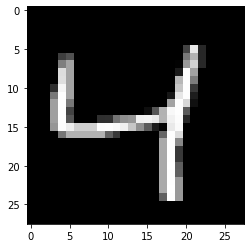

In [5]:
plt.imshow(x_train[2].reshape((28,28)), cmap="gray")
x_train.shape

In [6]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [7]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [8]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

Our new layer

In [45]:
class Linear_Adric(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.has_bias = bias
        #rand takes row, column
        self.param = torch.nn.Parameter(torch.rand(in_features, out_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.rand(out_features))
        
        
    def forward(self, input):
        #print(input)
        result = torch.matmul(input, self.param)
        if self.has_bias:
            result += self.bias
        return result

In [79]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = Linear_Adric(784, 50)
        self.lin2 = Linear_Adric(50, 10)

    def forward(self, xb): 
        x = self.lin(xb)
        x = F.relu(x)
        return self.lin2(x)

In [80]:
model = Mnist_Logistic().cuda()

In [81]:
model

Mnist_Logistic(
  (lin): Linear_Adric()
  (lin2): Linear_Adric()
)

In [82]:
model.lin

Linear_Adric()

In [83]:
model(x).shape

torch.Size([64, 10])

In [84]:
[p.shape for p in model.parameters()]

[torch.Size([784, 50]),
 torch.Size([50]),
 torch.Size([50, 10]),
 torch.Size([10])]

In [85]:
lr=2e-2
#lr=.001

In [86]:
loss_func = nn.CrossEntropyLoss()

In [87]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [88]:
losses = [update(x,y,lr) for x,y in data.train_dl]

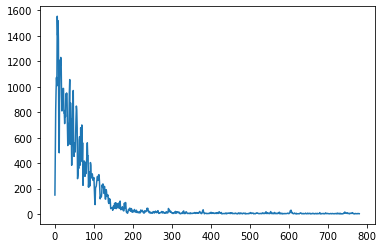

In [89]:
plt.plot(losses);